In [2]:
from model_architectures import VisionTransformerPretrained


In [3]:
checkpoint_path = "/Users/oliverfox/git_repositories/nih_cxr_project/vit_pretrained_fine_tune/best_model_epoch=33_val_loss=1.0432363748550415.ckpt"
model = VisionTransformerPretrained.load_from_checkpoint(checkpoint_path, strict=False)
model.eval()
                                                         
                                                         
                                            

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/oliverfox/venvs/ml_venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['loss_fn.pos_weight']


VisionTransformerPretrained(
  (backbone): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
   

In [4]:
target_layers = [model.backbone.vit.encoder.layer[11].attention.attention]

In [5]:
from datasets import load_dataset 

ds_test = load_dataset("alkzar90/NIH-Chest-X-ray-dataset", 'image-classification', split = "test") 

In [6]:
print((ds_test[0]['labels']))

[14]


tensor([[[[ 1.4509, -1.2001,  1.1142,  ...,  1.9655, -2.0513, -2.1461],
          [-3.9356, -3.2025, -1.8244,  ..., -2.7643, -4.0544, -5.0148],
          [-3.7251, -4.2185, -2.9720,  ..., -2.7211, -0.4451, -3.9793],
          ...,
          [-2.3072, -3.5424, -0.3041,  ..., -2.3890, -2.9566,  2.7364],
          [ 0.5938, -1.1894,  1.0510,  ..., -1.5997, -3.5512, -0.3205],
          [ 3.1130,  2.2675,  3.2182,  ..., -2.1857, -0.3083, -0.4621]],

         [[ 2.0634,  0.2125,  1.3784,  ...,  2.7752,  2.7462,  1.5744],
          [-3.1743,  0.4784,  1.5966,  ..., -1.2180,  1.2129, -0.9495],
          [-2.7892,  1.4543, -2.6345,  ..., -0.9839, -1.3718, -0.5157],
          ...,
          [-3.0813,  0.0698,  1.7061,  ..., -0.8741, -3.3275,  4.1690],
          [-1.0389, -1.9030, -1.3482,  ...,  0.8613,  1.3609,  0.2131],
          [ 3.6196, -1.0398, -0.4727,  ...,  0.0251,  0.2724, -0.4729]],

         [[-1.0551,  0.5752, -0.7978,  ..., -1.5029,  1.6045,  0.6723],
          [ 1.0786, -0.5079, -

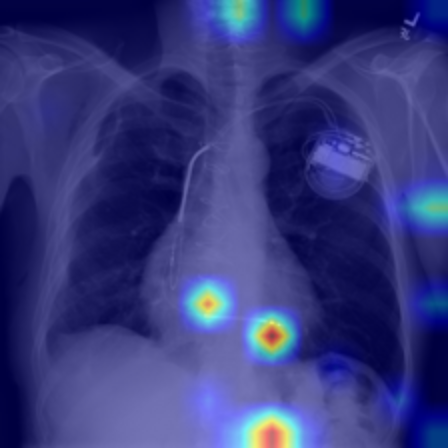

In [21]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import torch
from transformers import ViTForImageClassification
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from typing import List, Callable, Optional

# Model wrapper to return a tensor
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        
        # Deal with Huggingface outputs
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Take first element if tuple

        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        return outputs

# Helper function to run GradCAM on a single image and create a heatmap
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          reshape_transform: Callable,
                          input_tensor: torch.Tensor,
                          input_image: Image,
                          method: Callable = GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                target_layers=[target_layer],
                reshape_transform=reshape_transform) as cam:

        # Run Grad-CAM on the single image
        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0))[0]  # Add batch dimension

        # Create the heatmap visualization
        visualization = show_cam_on_image(np.float32(input_image) / 255,
                                          grayscale_cam,
                                          use_rgb=True)
        return visualization

# Define the reshape transform for ViT model
def reshape_transform_vit_huggingface(x):
    if isinstance(x, tuple):
        x = x[0]  # Take first element if it's a tuple
    
    # x shape: (batch_size, num_tokens, hidden_dim)
    activations = x[:, 1:, :]  # remove CLS token
    activations = activations.view(activations.shape[0], 14, 14, activations.shape[2])
    activations = activations.permute(0, 3, 1, 2)  # (B, C, H, W)
    print(activations)
    return activations

# Define the target layer for GradCAM
target_layer_gradcam = model.backbone.vit.encoder.layer[-2].output.dense
# Example usage for a single image
# Example usage for a single image
image = ds_test[50]['image']

# Ensure the image is a NumPy array
if isinstance(image, Image.Image):
    image = np.array(image)  # Convert PIL Image to NumPy array

# If it's grayscale, expand to 3 channels
if image.ndim == 2:  # (H, W)
    image = np.stack([image, image, image], axis=-1)  # Duplicate the single channel
elif image.shape[-1] == 1:  # (H, W, 1)
    image = np.concatenate([image, image, image], axis=-1)  # Duplicate the single channel

# Convert the NumPy array back to a PIL Image
image = Image.fromarray(image)

# Resize the input image to match the model's expected input size (224x224)
image_resized = image.resize((224, 224))

# Convert the resized image into a tensor
input_tensor = transforms.ToTensor()(image_resized)

# Run Grad-CAM on the single image
visualization = run_grad_cam_on_image(model=model,
                                      target_layer=target_layer_gradcam,
                                      input_tensor=input_tensor,
                                      input_image=np.array(image_resized),  # Convert back to NumPy for visualization
                                      reshape_transform=reshape_transform_vit_huggingface)

# Display the hea

# --- NEW: Normalize ---






# Resize for better viewing
visualization = cv2.resize(visualization, (visualization.shape[1] * 2, visualization.shape[0] * 2))


# Display
Image.fromarray(visualization)

In [19]:

image = ds_test[50]['image']

# Ensure the image is a NumPy array
if isinstance(image, Image.Image):
    image = np.array(image)  # Convert PIL Image to NumPy array

# If it's grayscale, expand to 3 channels
if image.ndim == 2:  # (H, W)
    image = np.stack([image, image, image], axis=-1)  # Duplicate the single channel
elif image.shape[-1] == 1:  # (H, W, 1)
    image = np.concatenate([image, image, image], axis=-1)  # Duplicate the single channel

# Convert the NumPy array back to a PIL Image
image = Image.fromarray(image)

# Resize the input image to match the model's expected input size (224x224)
image_resized = image.resize((224, 224))

# Convert the resized image into a tensor
input_tensor = transforms.ToTensor()(image_resized)
input_tensor = input_tensor.unsqueeze(0)
out = model(input_tensor)
torch.sigmoid(out)


tensor([[0.3447, 0.4960, 0.7131, 0.4779, 0.4947, 0.5069, 0.5000, 0.6671, 0.5034,
         0.4130, 0.2149, 0.7497, 0.7043, 0.6209, 0.0882]],
       grad_fn=<SigmoidBackward0>)

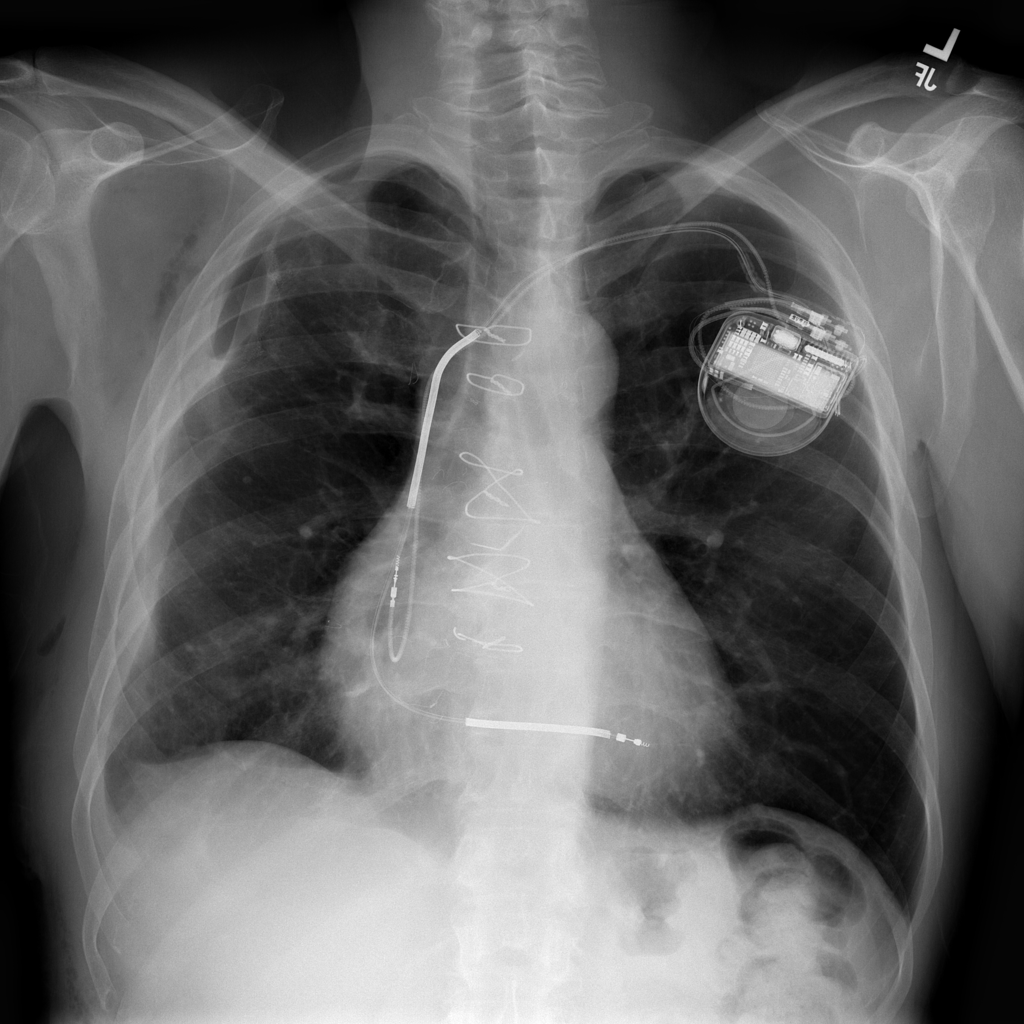

In [18]:
ds_test[50]['image']

In [20]:
ds_test[50]['labels']

[11]